In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [2]:
import os
import sys

inference_ipynb_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/light_sam_predict_example.ipynb'
BASE_DIR = os.path.dirname(
    os.path.dirname(os.path.dirname(inference_ipynb_path)))
sys.path.append(BASE_DIR)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torch.nn.functional as F

from simpleAICV.interactive_segmentation.models.light_segment_anything.light_sam import convformerm36_light_sam
from simpleAICV.interactive_segmentation.common import load_state_dict


sam_checkpoint = '/root/autodl-tmp/pretrained_models/light_sam_distill_on_sa_1b/student-epoch5-loss0.142.pth'

sam_model = convformerm36_light_sam(image_size=1024, 
                                    patch_size=16,                 
                                    use_gradient_checkpoint=False,
                                    frozen_image_encoder=False,
                                    frozen_prompt_encoder=False,
                                    frozen_mask_decoder=False,
                                    sigmoid_out=False,
                                    binary_mask_out=False,
                                    mask_threshold=0.0)
sam_model = sam_model.cuda()
sam_model = sam_model.eval()

load_state_dict(sam_checkpoint,sam_model)

no backbone pretrained model!
load/model weight nums:715/715
not loaded save layer weight:
[]


(1200, 1800, 3) uint8


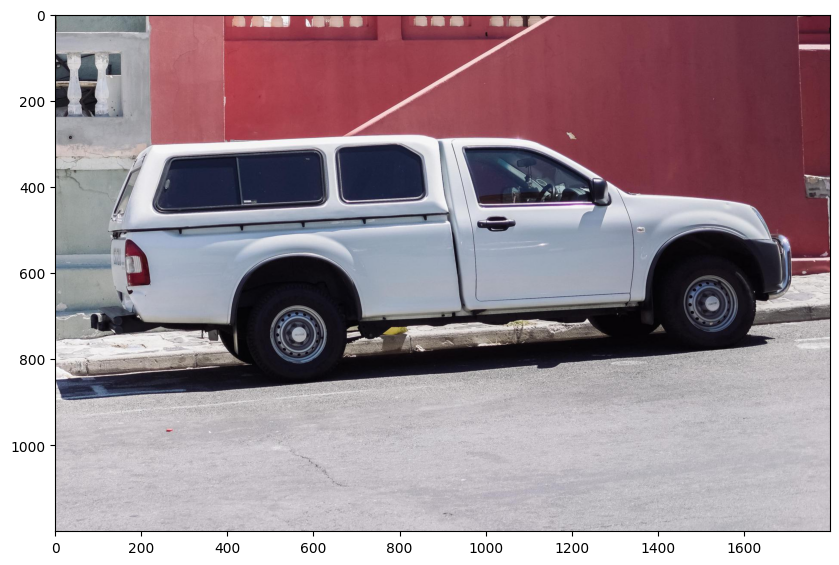

In [3]:
test_image_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/test_images/truck.jpg'
origin_image = cv2.imdecode(np.fromfile(test_image_path, dtype=np.uint8),
                        cv2.IMREAD_COLOR)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
print(origin_image.shape,origin_image.dtype)

plt.figure(figsize=(10,10))
plt.imshow(origin_image)
plt.axis('on')
plt.show()

(683, 1024, 3) uint8 0.5688888888888889


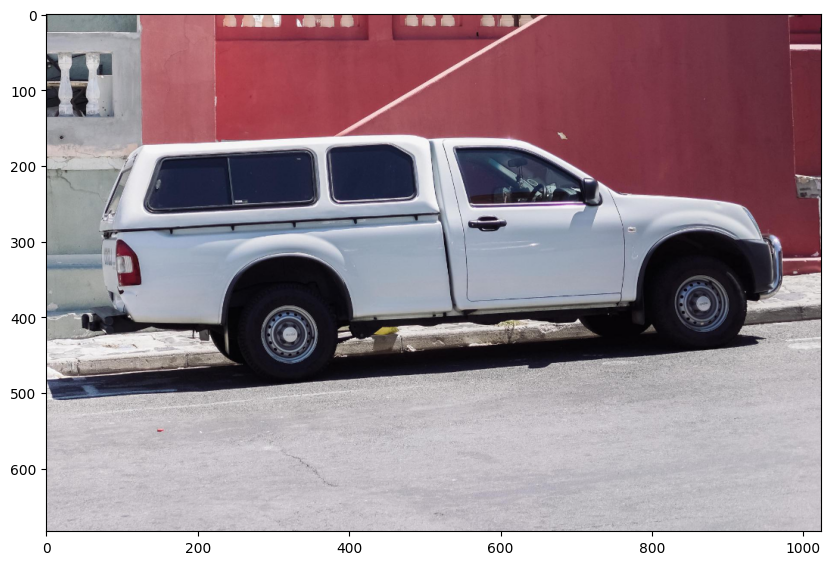

(683, 1024, 3) 2.64 -2.1179039301310043
(1024, 1024, 3) 2.64 -2.117904
torch.Size([1, 3, 1024, 1024]) tensor(2.6400, device='cuda:0') tensor(-2.1179, device='cuda:0')


In [4]:
origin_h, origin_w = origin_image.shape[0], origin_image.shape[1]
factor = 1024 / max(origin_h, origin_w)
resize_h, resize_w = int(round(origin_h * factor)), int(
    round(origin_w * factor))
resized_image = cv2.resize(origin_image, (resize_w, resize_h))
print(resized_image.shape,resized_image.dtype,factor)

plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
plt.axis('on')
plt.show()

mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]
norm_image = (resized_image - mean) / std
print(norm_image.shape,np.max(norm_image),np.min(norm_image))

padded_img = np.zeros((max(resize_h, resize_w), max(resize_h, resize_w), 3),
                        dtype=np.float32)
padded_img[:resize_h, :resize_w, :] = norm_image
print(padded_img.shape,np.max(padded_img),np.min(padded_img))


padded_img = torch.tensor(padded_img).float().cuda().permute(2, 0, 1).unsqueeze(0)
print(padded_img.shape,torch.max(padded_img),torch.min(padded_img))

(1, 2) (1, 1)
(1, 3)


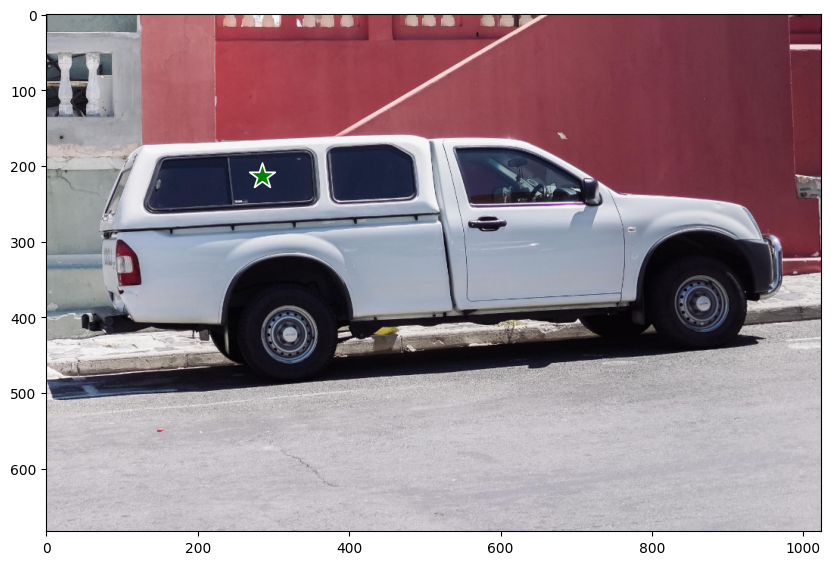

In [5]:
input_point = np.array([[500, 375]])*factor
# if positive point, input label = 1 ,elif negative point, input label = 0
input_label = np.array([[1]])
print(input_point.shape,input_label.shape)

prompt_point=np.concatenate([input_point,input_label],axis=1)
print(prompt_point.shape)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_points(input_point, input_label[0], plt.gca())
plt.axis('on')
plt.show()

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 3]) torch.float32 torch.float32
torch.Size([4, 1024, 1024]) torch.Size([4]) tensor([0.8278, 0.9910, 0.9512, 0.9353], device='cuda:0')


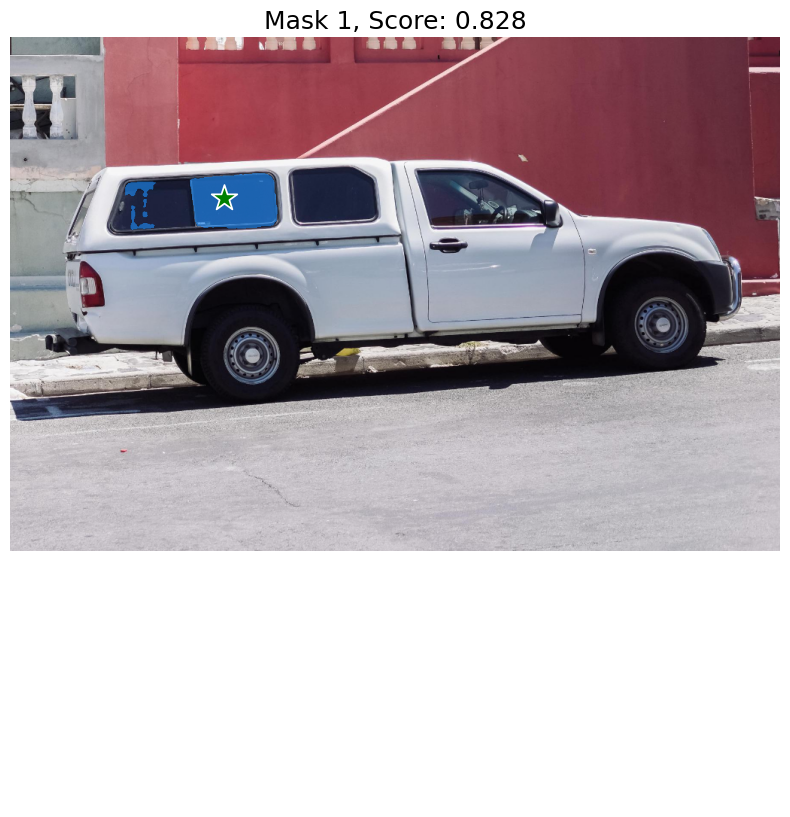

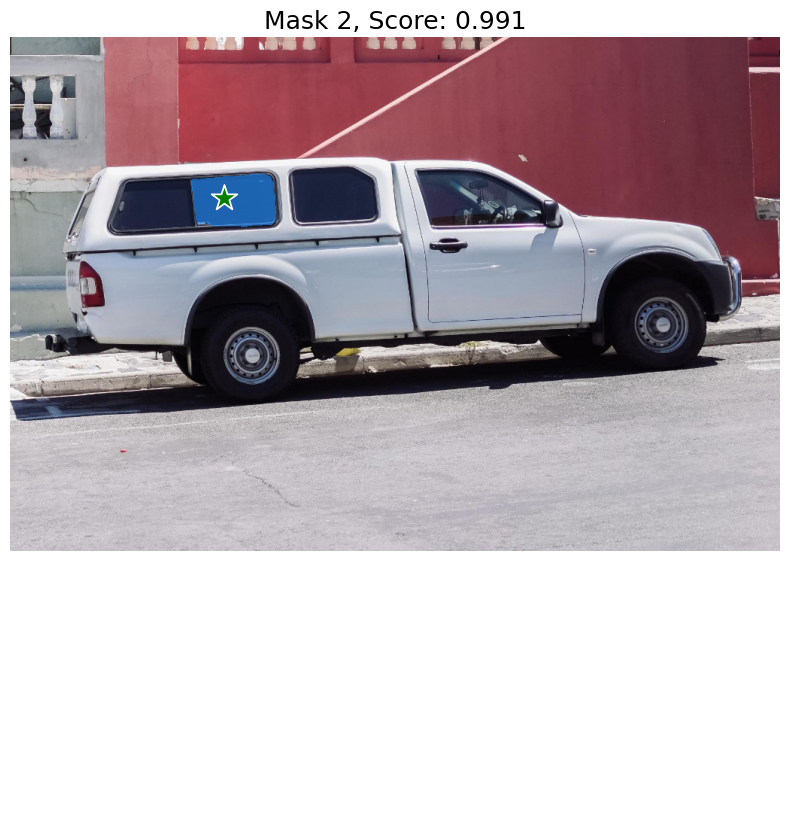

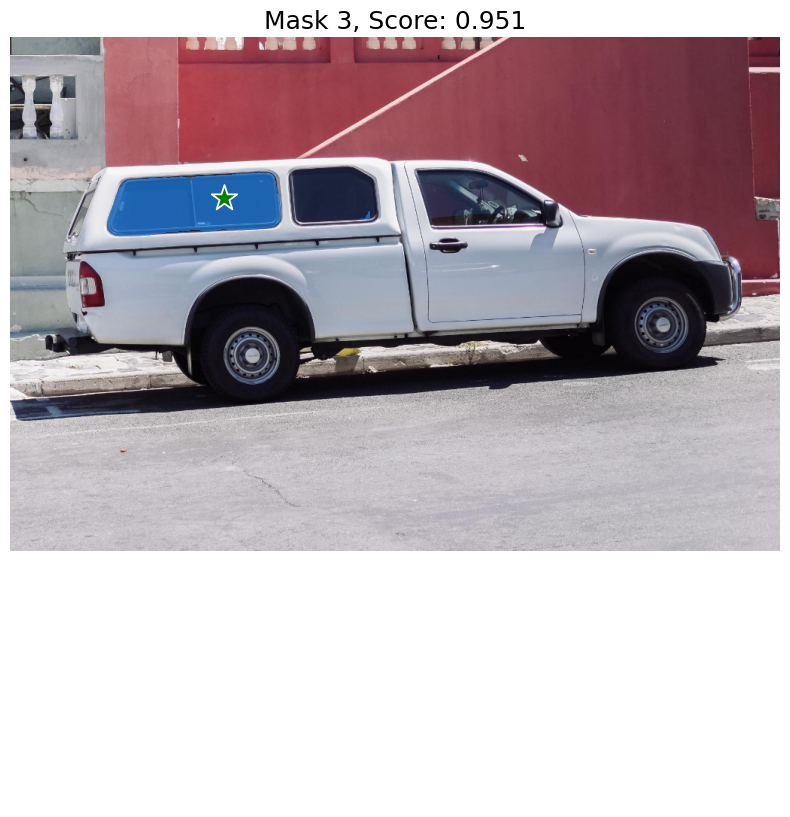

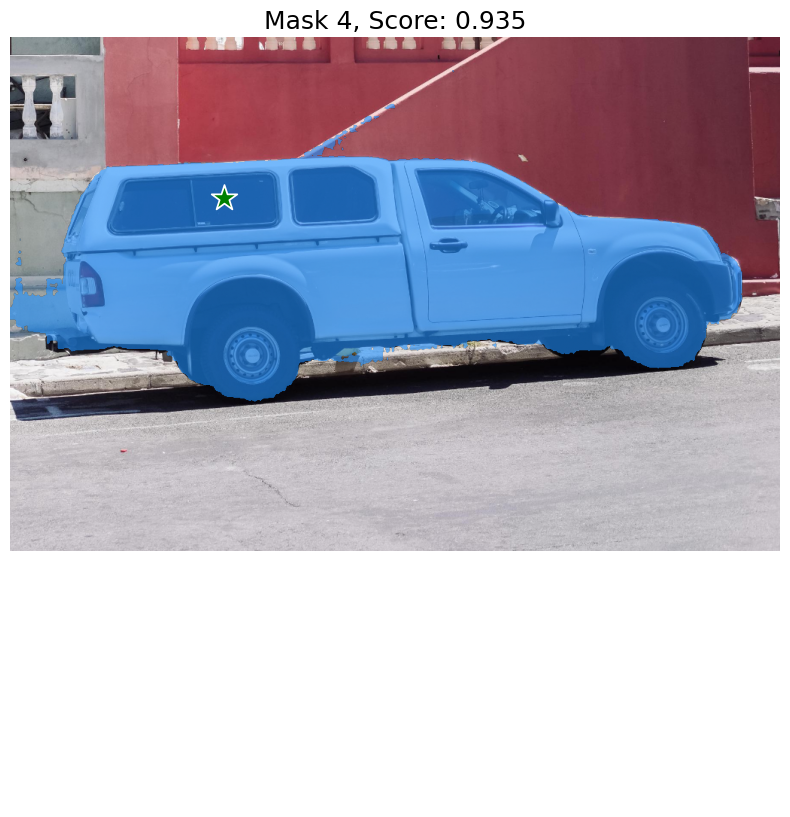

In [6]:
input_prompt_point = torch.tensor(np.expand_dims(prompt_point,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_point.shape,padded_img.dtype,input_prompt_point.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':input_prompt_point,
                'prompt_box':None,
                'prompt_mask':None}

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images, batch_prompts, mask_out_idxs=[0, 1, 2, 3])
    masks,iou_preds = batch_mask_outputs[0], batch_iou_outputs[0]
    binary_masks = masks > 0.
print(masks.shape,iou_preds.shape,iou_preds)


for i, (mask, score) in enumerate(zip(binary_masks, iou_preds)):
    mask=mask.cpu().numpy()
    score=score.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(resized_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label[0], plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

(2, 2) (2, 1)
(2, 3)
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 2, 3]) torch.float32 torch.float32
torch.Size([1, 1024, 1024]) torch.Size([1]) tensor([1.0024], device='cuda:0')


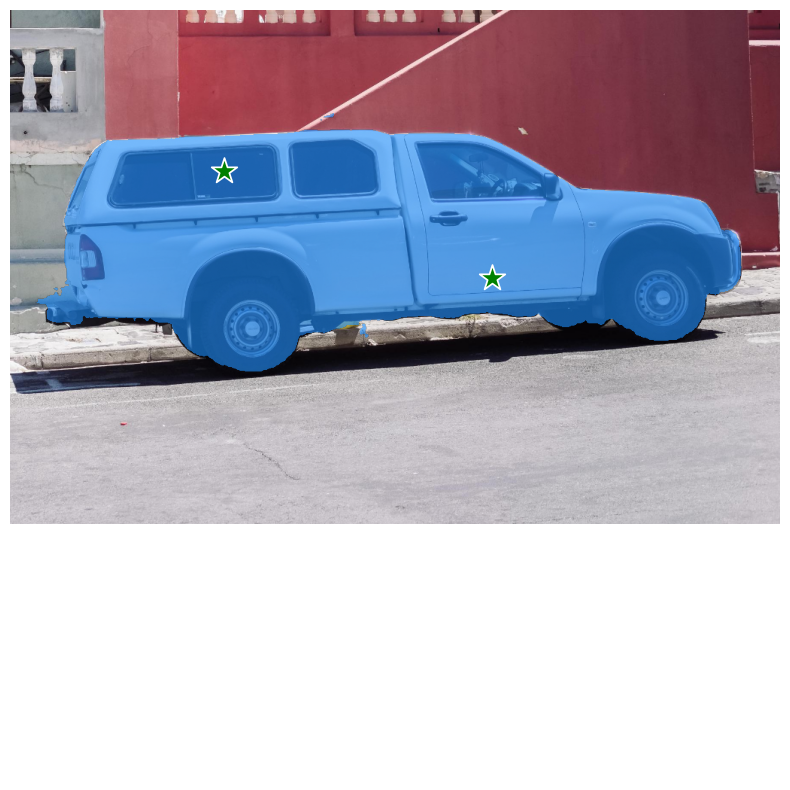

In [7]:
input_point = np.array([[500, 375], [1125, 625]])*factor
input_label = np.array([[1], [1]])
print(input_point.shape,input_label.shape)

prompt_point = np.concatenate([input_point,input_label],axis=1)
print(prompt_point.shape)

# Choose the model's best mask
prompt_mask = masks.clone().unsqueeze(0).float()
prompt_mask = F.interpolate(prompt_mask,(256, 256), mode = "nearest")
input_prompt_mask = prompt_mask[:,3:4,:,:]
print(input_prompt_mask.shape)

input_prompt_point = torch.tensor(np.expand_dims(prompt_point,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_point.shape,padded_img.dtype,input_prompt_point.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':input_prompt_point,
                'prompt_box':None,
                'prompt_mask':input_prompt_mask}

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images, batch_prompts, mask_out_idxs=[0])
    masks2,iou_preds2 = batch_mask_outputs[0], batch_iou_outputs[0]
    masks2 = masks2 > 0.
print(masks2.shape,iou_preds2.shape,iou_preds2)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_mask(masks2.cpu().numpy()[0], plt.gca())
show_points(input_point, np.squeeze(input_label,axis=1), plt.gca())
plt.axis('off')
plt.show() 

(2, 2) (2, 1)
(2, 3)
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 2, 3]) torch.float32 torch.float32
torch.Size([1, 1024, 1024]) torch.Size([1]) tensor([0.9561], device='cuda:0')


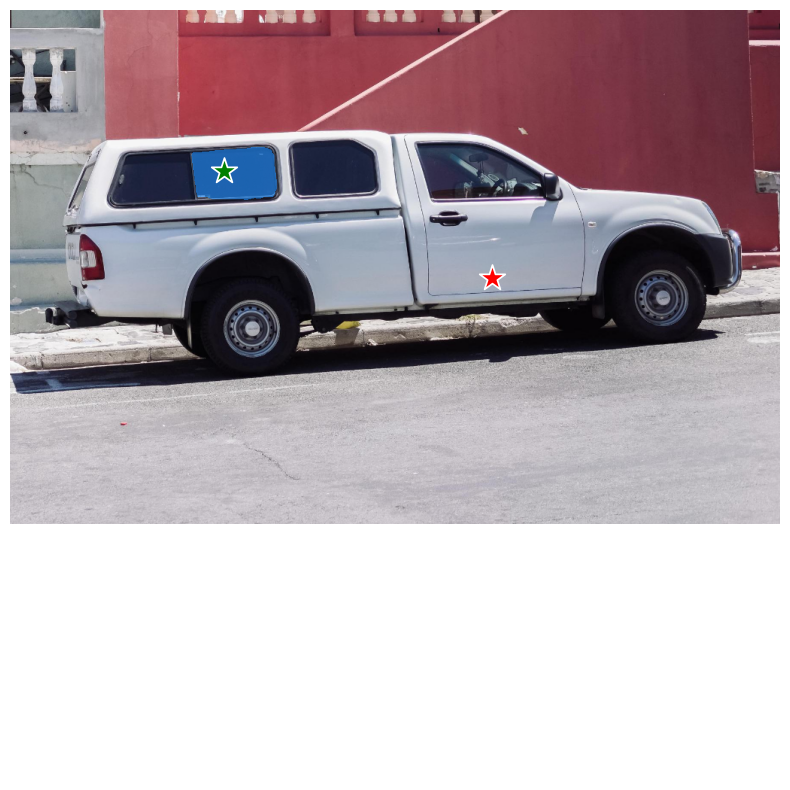

In [8]:
input_point = np.array([[500, 375], [1125, 625]])*factor
input_label = np.array([[1], [0]])
print(input_point.shape,input_label.shape)

prompt_point = np.concatenate([input_point,input_label],axis=1)
print(prompt_point.shape)

# Choose the model's best mask
prompt_mask = masks.clone().unsqueeze(0).float()
prompt_mask = F.interpolate(prompt_mask,(256, 256), mode = "nearest")
input_prompt_mask = prompt_mask[:,1:2,:,:]
print(input_prompt_mask.shape)

input_prompt_point = torch.tensor(np.expand_dims(prompt_point,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_point.shape,padded_img.dtype,input_prompt_point.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':input_prompt_point,
                'prompt_box':None,
                'prompt_mask':input_prompt_mask}

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images, batch_prompts, mask_out_idxs=[0])
    masks3,iou_preds3 = batch_mask_outputs[0], batch_iou_outputs[0]
    masks3 = masks3 > 0.
print(masks3.shape,iou_preds3.shape,iou_preds3)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_mask(masks3.cpu().numpy()[0], plt.gca())
show_points(input_point, np.squeeze(input_label,axis=1), plt.gca())
plt.axis('off')
plt.show() 

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 4]) torch.float32 torch.float32
torch.Size([1, 1024, 1024]) torch.Size([1]) tensor([0.9523], device='cuda:0')


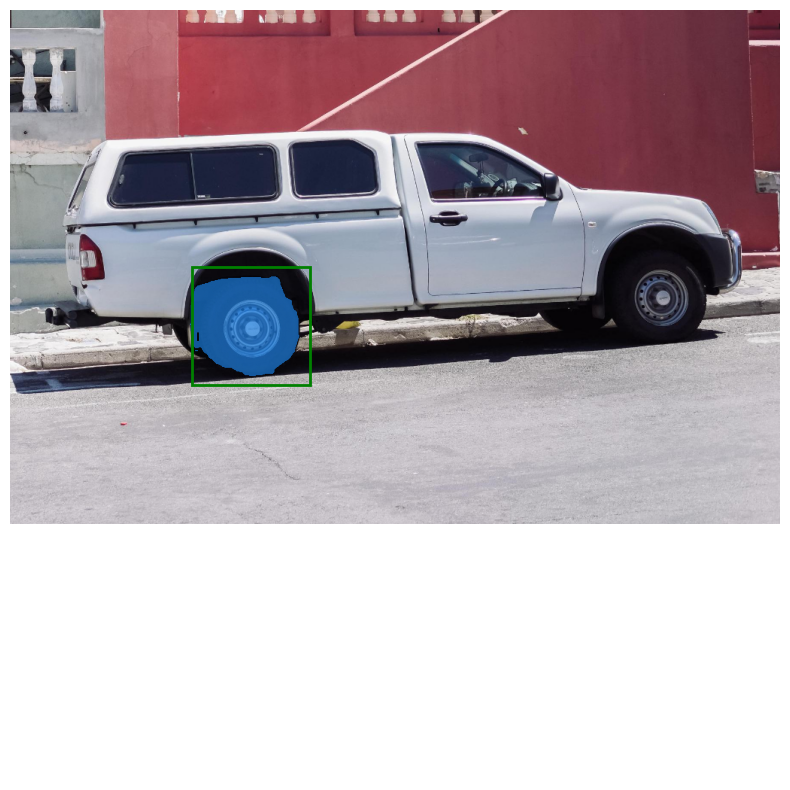

In [9]:
input_box = np.array([425, 600, 700, 875])*factor

input_prompt_box = torch.tensor(np.expand_dims(input_box,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_box.shape,padded_img.dtype,input_prompt_box.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':None,
                'prompt_box':input_prompt_box,
                'prompt_mask':None}

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images, batch_prompts, mask_out_idxs=[0])
    masks4,iou_preds4 = batch_mask_outputs[0], batch_iou_outputs[0]
    masks4 = masks4 > 0.
print(masks4.shape,iou_preds4.shape,iou_preds4)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_mask(masks4.cpu().numpy()[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

(4,) (1, 2) (1, 1)
(1, 3)
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 3]) torch.float32 torch.float32
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 4]) torch.float32 torch.float32
torch.Size([1024, 1024]) torch.Size([]) tensor(0.9351, device='cuda:0')


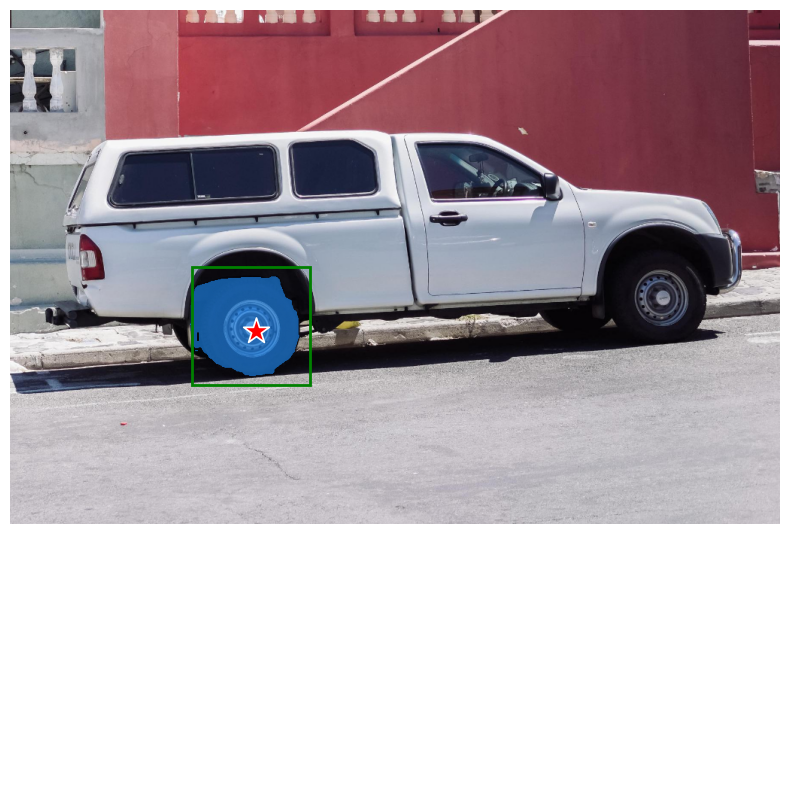

In [10]:
input_box = np.array([425, 600, 700, 875])*factor
input_point = np.array([[575, 750]])*factor
input_label = np.array([[0]])
print(input_box.shape,input_point.shape,input_label.shape)

prompt_point = np.concatenate([input_point,input_label],axis=1)
print(prompt_point.shape)

input_prompt_point = torch.tensor(np.expand_dims(prompt_point,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_point.shape,padded_img.dtype,input_prompt_point.dtype)

input_prompt_box = torch.tensor(np.expand_dims(input_box,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_box.shape,padded_img.dtype,input_prompt_box.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':input_prompt_point,
                'prompt_box':input_prompt_box,
                'prompt_mask':None}

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images,batch_prompts, mask_out_idxs=[0])
    masks5,iou_preds5 = batch_mask_outputs[0][0], batch_iou_outputs[0][0]
    masks5 = masks5 > 0.
print(masks5.shape,iou_preds5.shape,iou_preds5)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_mask(masks4.cpu().numpy()[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label[0], plt.gca())
plt.axis('off')
plt.show() 

(4, 4)
torch.Size([1, 3, 1024, 1024]) torch.Size([4, 4]) torch.float32 torch.float32
torch.Size([4, 1, 1024, 1024]) torch.Size([4, 1]) tensor([[0.9595],
        [0.9523],
        [0.9515],
        [0.9326]], device='cuda:0')


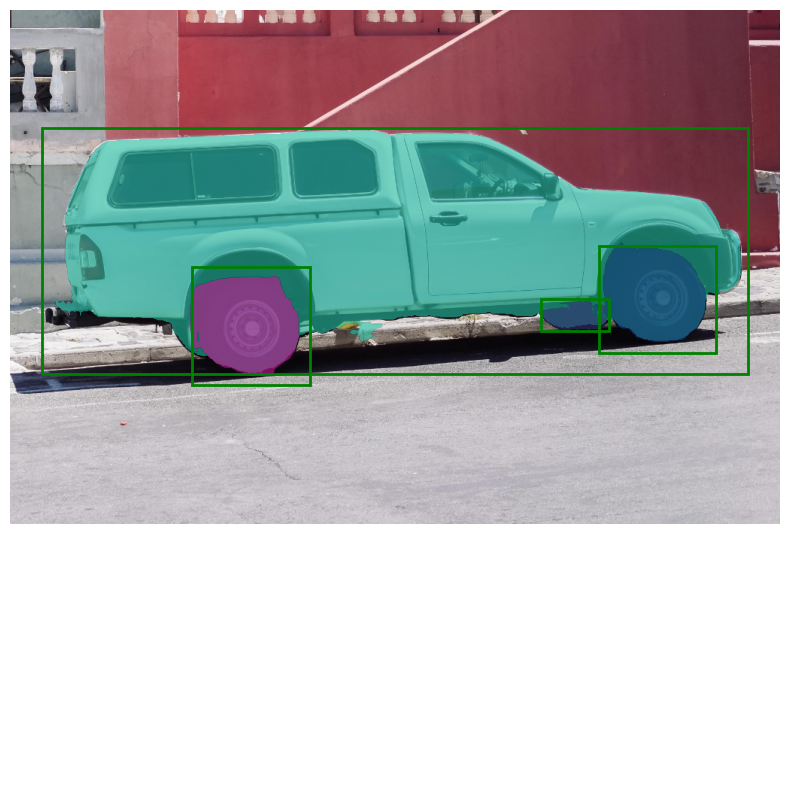

In [11]:
input_box = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750]])*factor
print(input_box.shape)

input_prompt_box = torch.tensor(input_box).float().cuda()
print(padded_img.shape,input_prompt_box.shape,padded_img.dtype,input_prompt_box.dtype)

batch_images = padded_img.clone()
batch_images = torch.repeat_interleave(batch_images, input_box.shape[0], dim=0)
batch_prompts = {'prompt_point':None,
                'prompt_box':input_prompt_box,
                'prompt_mask':None} 

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images,batch_prompts, mask_out_idxs=[0])
    masks6, iou_preds6 = batch_mask_outputs, batch_iou_outputs
    masks6 = masks6 > 0.
print(masks6.shape,iou_preds6.shape,iou_preds6)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
for i, mask in enumerate(masks6):
    mask=mask.cpu().numpy()[0]
    show_mask(mask, plt.gca(), random_color=True)
    show_box(input_box[i], plt.gca())
plt.axis('off')
plt.show()

(684, 1024, 3) uint8 1.28
(684, 1024, 3) 2.64 -2.1179039301310043
(1024, 1024, 3) 2.64 -2.117904
torch.Size([1, 3, 1024, 1024]) tensor(2.6400, device='cuda:0') tensor(-2.1179, device='cuda:0')
torch.Size([1, 3, 1024, 1024]) torch.Size([4, 4]) torch.float32 torch.float32
torch.Size([4, 1, 1024, 1024]) torch.Size([4, 1]) tensor([[0.9557],
        [0.9696],
        [0.9616],
        [0.9542]], device='cuda:0')


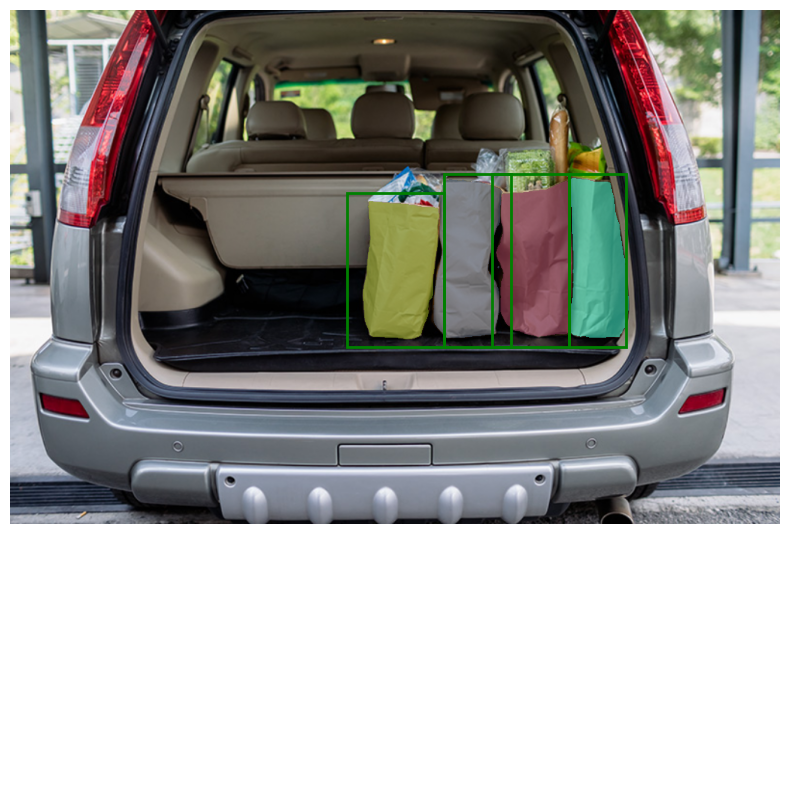

In [12]:
test_image_path2='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/test_images/groceries.jpg'
origin_image2 = cv2.imdecode(np.fromfile(test_image_path2, dtype=np.uint8),
                        cv2.IMREAD_COLOR)
origin_image2 = cv2.cvtColor(origin_image2, cv2.COLOR_BGR2RGB)
origin_h2, origin_w2 = origin_image2.shape[0], origin_image2.shape[1]
factor2 = 1024 / max(origin_h2, origin_w2)
resize_h2, resize_w2 = int(round(origin_h2 * factor2)), int(
    round(origin_w2 * factor2))
resized_image2 = cv2.resize(origin_image2, (resize_w2, resize_h2))
print(resized_image2.shape,resized_image2.dtype,factor2)

mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]
norm_image2 = (resized_image2 - mean) / std
print(norm_image2.shape,np.max(norm_image2),np.min(norm_image2))

padded_img2 = np.zeros((max(resize_h2, resize_w2), max(resize_h2, resize_w2), 3),
                        dtype=np.float32)
padded_img2[:resize_h2, :resize_w2, :] = norm_image2
print(padded_img2.shape,np.max(padded_img2),np.min(padded_img2))

padded_img2 = torch.tensor(padded_img2).float().cuda().permute(2, 0, 1).unsqueeze(0)
print(padded_img2.shape,torch.max(padded_img2),torch.min(padded_img2))

input_box2 = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350]])*factor2

input_prompt_box2 = torch.tensor(input_box2).float().cuda()
print(padded_img2.shape, input_prompt_box2.shape,padded_img2.dtype, input_prompt_box2.dtype)

batch_images2 = padded_img2.clone()
batch_images2 = torch.repeat_interleave(batch_images2, input_box2.shape[0], dim=0)
batch_prompts2 = {'prompt_point':None,
                'prompt_box':input_prompt_box2,
                'prompt_mask':None} 

with torch.no_grad():
    batch_mask_outputs, batch_iou_outputs = sam_model(batch_images2,batch_prompts2, mask_out_idxs=[0])
    masks7, iou_preds7 = batch_mask_outputs, batch_iou_outputs
    masks7 = masks7 > 0.
print(masks7.shape,iou_preds7.shape,iou_preds7)

plt.figure(figsize=(10,10))
plt.imshow(resized_image2)
for i, mask in enumerate(masks7):
    mask=mask.cpu().numpy()[0]
    show_mask(mask, plt.gca(), random_color=True)
    show_box(input_box2[i], plt.gca())
plt.axis('off')
plt.show()